```
---
title: BioPAX pathway
tags: BioPAX, pathway, SPARQL, Reactome
lang: en
version: 0.11
date: 2024-02-28
---
```

In [1]:
import collections
import graphviz
import importlib
import IPython
import json
import matplotlib.pyplot as plt
import networkx as nx
import os
import pandas
import pygraphviz as pgv
import rdflib
import rdflib.namespace
import scipy.stats
import sparqldataframe
import statsmodels.stats.multitest
from SPARQLWrapper import SPARQLWrapper, JSON
import sys

In [2]:
reactomeVersion = 65 # was 84 # was 81
#chebiVersion = 222 # was 219 # was 207
endpointURL = "http://localhost:3030/reactome/query"
#endpointURL = "http://localhost:3030/chebi/query"
#endpointURL = "http://localhost:3030/reactomeChEBI/query"
rdfFormat = "turtle"

In [3]:
prefixes = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>

PREFIX chebi: <http://purl.obolibrary.org/obo/chebi/>
PREFIX chebidb: <http://purl.obolibrary.org/obo/CHEBI_>
PREFIX chebirel: <http://purl.obolibrary.org/obo/CHEBI#>
PREFIX oboInOwl: <http://www.geneontology.org/formats/oboInOwl#>

PREFIX bp3: <http://www.biopax.org/release/biopax-level3.owl#>

# Homo_sapiens-20170221.owl
#PREFIX reactome: <http://www.reactome.org/biopax/59/48887#> 
#
# Homo_sapiens-20210608.owl
#PREFIX reactome: <http://www.reactome.org/biopax/77/48887#>
#
# Homo_sapiens-20220614.owl
#PREFIX reactome: <http://www.reactome.org/biopax/81/48887#>
#
# Homo_sapiens-20221130.owl
#PREFIX reactome: <http://www.reactome.org/biopax/83/48887#>

PREFIX reactome: <http://www.reactome.org/biopax/{}/48887#>
""".format(reactomeVersion)

biopaxURI = "http://www.biopax.org/release/biopax-level3.owl#"

In [4]:
colorPathway = "#e6ffff"
colorPathwayStep = "#e8ffe8"
colorReaction = "lightyellow"

In [5]:
def displaySparqlResults(results):
    '''
    Displays as HTML the result of a SPARQLWrapper query in a Jupyter notebook.
    
        Parameters:
            results (dictionnary): the result of a call to SPARQLWrapper.query().convert()
    '''
    variableNames = results['head']['vars']
    tableCode = '<table><tr><th>{}</th></tr><tr>{}</tr></table>'.format('</th><th>'.join(variableNames), '</tr><tr>'.join('<td>{}</td>'.format('</td><td>'.join([row[vName]['value'] if vName in row.keys() else "&nbsp;" for vName in variableNames]))for row in results["results"]["bindings"]))
    IPython.display.display(IPython.display.HTML(tableCode))

In [6]:
def getPathwayURIbyName(pathwayName):
    query="""
SELECT DISTINCT ?pathwayURI ?pathwayReactomeID
WHERE {
  ?pathwayURI bp3:name|bp3:displayName \"""" + pathwayName + """\" .
  ?pathwayURI bp3:xref [ rdf:type bp3:UnificationXref ;
                      bp3:db "Reactome" ;
                      bp3:id ?pathwayReactomeID ] .
}
"""
    #df = sparqldataframe.query(endpointURL, prefixes+query)
    #df

    sparql = SPARQLWrapper(endpointURL)
    sparql.setQuery(prefixes+query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    return results

In [7]:
def getPathwayURIandNameByIdent(pathwayReactomeID):
    query="""
SELECT DISTINCT ?pathwayURI ?pathwayName
WHERE {
  #?pathwayURI bp3:name ?pathwayName .
  ?pathwayURI bp3:displayName ?pathwayName .
  #?pathwayURI bp3:name|bp3:displayName ?pathwayName .
  ?pathwayURI bp3:xref [ rdf:type bp3:UnificationXref ;
                      bp3:db "Reactome" ;
                      bp3:id \"""" + pathwayReactomeID + """\" ] .
}
"""
    #df = sparqldataframe.query(endpointURL, prefixes+query)
    #df

    sparql = SPARQLWrapper(endpointURL)
    sparql.setQuery(prefixes+query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    return results

In [8]:
displaySparqlResults(getPathwayURIbyName("Epidermal Growth Factor Receptor (EGFR) signaling"))

In [8]:
displaySparqlResults(getPathwayURIandNameByIdent("R-HSA-8981373"))

In [9]:
displaySparqlResults(getPathwayURIbyName("FGFR1 ligand binding and activation"))

# BioPAX Data schema

![Biopax instance diagram (Reactome)](./images/biopax-v3.png)

In [5]:
query="""
# properties applicable to Pathways

SELECT DISTINCT ?rel
WHERE {
  ?pathway rdf:type bp3:Pathway .
  ?pathway ?rel ?val .
}
ORDER BY ?rel
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

![BioPAX pathway identification](./images/biopax-v3-pathway-identification.png)

# Metrics

In [6]:
query="""
# Instances

SELECT DISTINCT ?classOfInterest (COUNT(DISTINCT ?instance) AS ?nbInstances)
WHERE {
  VALUES ?classOfInterest { bp3:Pathway bp3:PathwayStep bp3:BiochemicalReaction bp3:Control bp3:Complex bp3:SmallMolecule }
  ?instance rdf:type/(rdfs:subClassOf*) ?classOfInterest .
  #OPTIONAL { ?classOfInterest rdfs:label ?classOfInterestLabel }
}
GROUP BY ?classOfInterest ?classOfInterestLabel
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

# EGFR-related pathways

In [7]:
query="""
# EGFR-related pathways

SELECT DISTINCT ?pathway ?pathwayName ?sourceName ?db ?id
WHERE {
  ?pathway rdf:type bp3:Pathway .
  ?pathway bp3:name ?pathwayName .
  FILTER (CONTAINS(LCASE(?pathwayName), "egf"))
  OPTIONAL {?pathway bp3:dataSource/bp3:name ?sourceName .}
  OPTIONAL {
    ?pathway bp3:xref ?xref .
    ?xref rdf:type bp3:UnificationXref .
    ?xref bp3:db ?db .
    ?xref bp3:id ?id .
  }
}
ORDER BY ?pathway
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

> **WARNING:** this query returns 2 pathways whereas Reactome website finds 44 pathways containing "EGF"

![Reactome website finds 44 pathways containing EGF](./images/reactome-website-EGF.png)

In [8]:
query="""
# EGFR-related pathways

SELECT DISTINCT ?pathway ?pathwayType ?pathwayName ?xrefType ?db
WHERE {
  ?pathway rdf:type ?pathwayType .
  ?pathway bp3:name ?pathwayName .
  
  ?pathway bp3:xref ?xref .
  ?xref rdf:type ?xrefType .
  ?xref bp3:db ?db .
  ?xref bp3:id "R-HSA-182971" .
}
ORDER BY ?pathway
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

In [9]:
query="""
# EGFR-related pathways

SELECT DISTINCT ?xref ?db
WHERE {
  ?xref rdf:type ?xrefType .
  ?xref bp3:db ?db .
  ?xref bp3:id "R-HSA-182971" .
}
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

In [10]:
query="""
# EGFR-related pathways: why did we not retrieve R-HSA-182971 ?

SELECT DISTINCT ?pathway
WHERE {
  ?pathway bp3:xref ?xref .
  ?pathway rdf:type ?pathwayType .
  #?pathway bp3:name ?pathwayName .
  
  ?xref rdf:type bp3:UnificationXref .
  ?xref bp3:db "Reactome" .
  ?xref bp3:id "R-HSA-182971" .
}
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

In [11]:
query="""
# EGFR-related pathways: why did we not retrieve R-HSA-182971 ?

SELECT DISTINCT ?rel
WHERE {
  ?pathway bp3:xref ?xref .
  ?pathway rdf:type ?pathwayType .
  #?pathway bp3:name ?pathwayName .
  
  ?xref rdf:type bp3:UnificationXref .
  ?xref bp3:db "Reactome" .
  ?xref bp3:id "R-HSA-182971" .
  
  ?pathway ?rel ?val .
}
ORDER BY ?rel
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

> **Interpretation:** `bp3:displayName` is used more than `bp3:name`

In [12]:
query="""
# EGFR-related pathways

SELECT DISTINCT ?pathway ?id ?pathwayName 
#SELECT DISTINCT ?id ?pathwayName 
WHERE {
  ?pathway rdf:type bp3:Pathway .
  ?pathway bp3:name|bp3:displayName ?pathwayName .
  FILTER (CONTAINS(LCASE(?pathwayName), "egfr"))
  OPTIONAL {
    ?pathway bp3:xref ?xref .
    ?xref rdf:type bp3:UnificationXref .
    ?xref bp3:db "Reactome" .
    ?xref bp3:id ?id .
  }
}
ORDER BY ?pathway
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

# Pathway components

## Pathway component ancestors 

In [26]:
def addPathwayComponentAncestors(pathwayURI, defaultPrefixName = "reactome", defaultPrefixValue = "http://www.reactome.org/biopax/{}/48887#".format(reactomeVersion), graph=None):
    if graph is None:
        graph = pgv.AGraph(directed=True, strict=True, rankdir='BT')
    pathwayIdent = pathwayURI
    if pathwayIdent.startswith(defaultPrefixValue):
        pathwayIdent = pathwayIdent.replace(defaultPrefixValue, defaultPrefixName + ':')
    if not(pathwayIdent.startswith(defaultPrefixName + ':')):
        pathwayIdent = "<" + pathwayIdent + ">"
    query = """
SELECT DISTINCT ?pathwayChild ?pathwayChildName ?pathwayChildReactome ?pathwayParent ?pathwayParentName ?pathwayParentReactome 
WHERE {
  VALUES ?pathwayStart { """ + pathwayIdent + """ }

  ?pathwayChild bp3:pathwayComponent* ?pathwayStart .
  ?pathwayChild bp3:displayName ?pathwayChildName .
  ?pathwayChild bp3:xref [ rdf:type bp3:UnificationXref ;
                      bp3:db "Reactome" ;
                      bp3:id ?pathwayChildReactome ] .
  
  ?pathwayParent bp3:pathwayComponent ?pathwayChild .
  ?pathwayParent bp3:displayName ?pathwayParentName .
  ?pathwayParent bp3:xref [ rdf:type bp3:UnificationXref ;
                      bp3:db "Reactome" ;
                      bp3:id ?pathwayParentReactome ] .
}
"""
    sparql = SPARQLWrapper(endpointURL)
    sparql.setQuery(prefixes + query)
    sparql.setReturnFormat(JSON)
    results = sparql.queryAndConvert()
    for result in results["results"]["bindings"]:
        childID = result["pathwayChild"]["value"].replace(defaultPrefixValue, "")
        parentID = result["pathwayParent"]["value"].replace(defaultPrefixValue, "")
        nodeColor = "white"
        borderColor = "black"
        if not(graph.has_node(defaultPrefixName+childID)):
        #if defaultPrefixName+childID not in graph.nodes():
            graph.add_node(defaultPrefixName+childID, label="{}\n{}\n{}:{}".format(result["pathwayChildName"]["value"], result["pathwayChildReactome"]["value"], defaultPrefixName, childID), shape="box", style="filled", fillcolor=nodeColor, color=borderColor)
        if result["pathwayChild"]["value"] == pathwayURI:
            graph.get_node(defaultPrefixName+childID).attr["color"] = "red"
        
        nodeColor = "white"
        borderColor = "black"
        if not(graph.has_node(defaultPrefixName+parentID)):
        #if defaultPrefixName+parentID not in graph.nodes():
            graph.add_node(defaultPrefixName+parentID, label="{}\n{}\n{}:{}".format(result["pathwayParentName"]["value"], result["pathwayParentReactome"]["value"], defaultPrefixName, parentID), shape="box", style="filled", fillcolor=nodeColor, color=borderColor)
        if result["pathwayParent"]["value"] == pathwayURI:
            graph.get_node(defaultPrefixName+parentID).attr["color"] = "red"
        
        graph.add_edge(defaultPrefixName+childID, defaultPrefixName+parentID, arrowhead="onormal")
    return graph

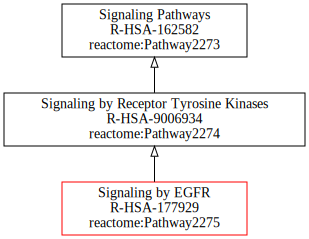

In [27]:
pathwayGraph = pgv.AGraph(directed=True, strict=True, rankdir='BT')
addPathwayComponentAncestors("http://www.reactome.org/biopax/65/48887#Pathway2275", defaultPrefixName = "reactome", defaultPrefixValue = "http://www.reactome.org/biopax/{}/48887#".format(reactomeVersion), graph = pathwayGraph)

display(IPython.core.display.SVG(pathwayGraph.draw(prog='dot',format='svg')))

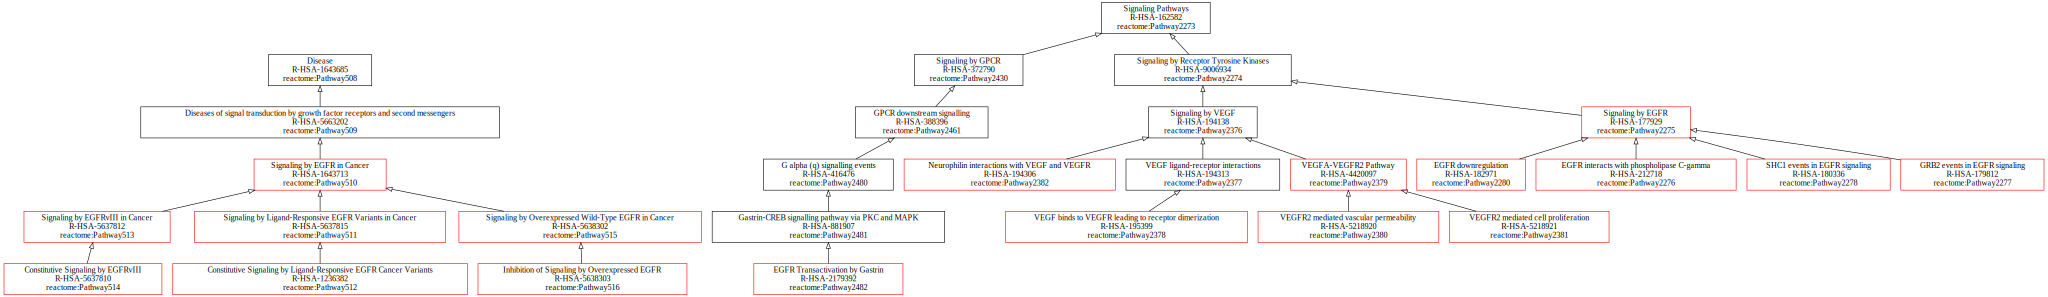

In [24]:
pathwayGraph = pgv.AGraph(directed=True, strict=True, rankdir='BT')

query="""
# EGFR-related pathways

SELECT DISTINCT ?pathway
WHERE {
  ?pathway rdf:type bp3:Pathway .
  ?pathway bp3:name|bp3:displayName ?pathwayName .
  FILTER (CONTAINS(LCASE(?pathwayName), "egfr"))
}
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
for result in results["results"]["bindings"]:
    addPathwayComponentAncestors(result["pathway"]["value"], defaultPrefixName = "reactome", defaultPrefixValue = "http://www.reactome.org/biopax/{}/48887#".format(reactomeVersion), graph = pathwayGraph)

#pathwayGraph.draw("simple.png", prog="dot")
display(IPython.core.display.SVG(pathwayGraph.draw(prog='dot',format='svg')))

![Reactome browser for signaling by EGFR pathway](./images/reactome-browser-signaling_by_EGFR.png)

> **Interpetation:** Reactome browser shows that the "Signaling by EGFR" pathway is composed of 7 direct reactions and 5 direct subpathways.
> The diagram above shows the four direct subpathways that have "EGFR" in their name

## Pathway component descendants

In [13]:
pathwayGraph = pgv.AGraph(directed=True, strict=True, rankdir='BT')

query="""
# EGFR-related pathways

SELECT ?componentType (COUNT(DISTINCT ?component) AS ?nbComponents) (COUNT(DISTINCT ?step) AS ?nbSteps)
WHERE {
  VALUES ?pathwayStart { reactome:Pathway2275 }
  
  # DIRECT COMPONENTS
  #?pathwayStart bp3:pathwayComponent ?component .
  # INDIRECT COMPONENTS
  ?pathwayStart bp3:pathwayComponent+ ?component .
  
  ?pathwayStart (bp3:pathwayOrder/bp3:stepProcess)*/bp3:pathwayOrder ?step .
  ?step bp3:stepProcess/(bp3:pathwayOrder/bp3:stepProcess)* ?component .
  
  ?component rdf:type ?componentType
}
GROUP BY ?componentType
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

> **Interpretation:** Signaling by EGFR (`R-HSA-177929`) is composed of:
> - directly: 7 `bp3:BiochemicalReaction` and 5 `bp3:Pathway`
> - indirectly: 50 `bp3:BiochemicalReaction` and 5 `bp3:Pathway`
>
> |   | `bp3:BiochemicalReaction` | `bp3:Pathway` |
> | --- | --- | --- |
> | direct | 7 | 5 |
> | indirect | 50 | 5 |

In [35]:
def addPathwayComponentDirect(pathwayURI, defaultPrefixName = "reactome", defaultPrefixValue = "http://www.reactome.org/biopax/{}/48887#".format(reactomeVersion), onlyPathways=False, graphDirection='BT', graph=None):
    if graph is None:
        graph = pgv.AGraph(directed=True, strict=True, rankdir=graphDirection)
    pathwayIdent = pathwayURI
    if pathwayIdent.startswith(defaultPrefixValue):
        pathwayIdent = pathwayIdent.replace(defaultPrefixValue, defaultPrefixName + ':')
    if not(pathwayIdent.startswith(defaultPrefixName + ':')):
        pathwayIdent = "<" + pathwayIdent + ">"
    if onlyPathways:
        query = """
SELECT DISTINCT ?pathwayChild ?pathwayChildName ?pathwayChildReactome ?pathwayChildType ?pathwayParent ?pathwayParentName ?pathwayParentReactome 
WHERE {
  VALUES ?pathwayParent { """ + pathwayIdent + """ }
  
  ?pathwayParent rdf:type bp3:Pathway .
  ?pathwayParent bp3:displayName ?pathwayParentName .
  ?pathwayParent bp3:xref [ rdf:type bp3:UnificationXref ;
                      bp3:db "Reactome" ;
                      bp3:id ?pathwayParentReactome ] .
                      
  ?pathwayParent bp3:pathwayComponent ?pathwayChild .

  ?pathwayChild rdf:type bp3:Pathway .
  ?pathwayChild rdf:type ?pathwayChildType .
  ?pathwayChild bp3:displayName ?pathwayChildName .
  ?pathwayChild bp3:xref [ rdf:type bp3:UnificationXref ;
                      bp3:db "Reactome" ;
                      bp3:id ?pathwayChildReactome ] .
  
  
  
}
"""
    else:
        query = """
SELECT DISTINCT ?pathwayChild ?pathwayChildName ?pathwayChildReactome ?pathwayChildType ?pathwayParent ?pathwayParentName ?pathwayParentReactome 
WHERE {
  VALUES ?pathwayParent { """ + pathwayIdent + """ }
  
  ?pathwayParent bp3:displayName ?pathwayParentName .
  ?pathwayParent bp3:xref [ rdf:type bp3:UnificationXref ;
                      bp3:db "Reactome" ;
                      bp3:id ?pathwayParentReactome ] .
                      
  ?pathwayParent bp3:pathwayComponent ?pathwayChild .

  ?pathwayChild rdf:type ?pathwayChildType .
  ?pathwayChild bp3:displayName ?pathwayChildName .
  ?pathwayChild bp3:xref [ rdf:type bp3:UnificationXref ;
                      bp3:db "Reactome" ;
                      bp3:id ?pathwayChildReactome ] .
  
  
  
}
"""
    sparql = SPARQLWrapper(endpointURL)
    sparql.setQuery(prefixes + query)
    sparql.setReturnFormat(JSON)
    results = sparql.queryAndConvert()
    for result in results["results"]["bindings"]:
        childID = result["pathwayChild"]["value"].replace(defaultPrefixValue, "")
        parentID = result["pathwayParent"]["value"].replace(defaultPrefixValue, "")
        nodeColor = "white"
        borderColor = "black"
        if not(graph.has_node(defaultPrefixName+childID)):
        #if defaultPrefixName+childID not in graph.nodes():
            if result["pathwayChildType"]["value"] == biopaxURI + "Pathway":
                nodeColor = colorPathway
            elif result["pathwayChildType"]["value"] == biopaxURI + "BiochemicalReaction":
                nodeColor = colorReaction
            graph.add_node(defaultPrefixName+childID, label="{}\n{}\n{}:{}".format(result["pathwayChildName"]["value"], result["pathwayChildReactome"]["value"], defaultPrefixName, childID), shape="box", style="filled", fillcolor=nodeColor, color=borderColor)
        if result["pathwayChild"]["value"] == pathwayURI:
            graph.get_node(defaultPrefixName+childID).attr["color"] = "red"
        
        nodeColor = colorPathway # "white"
        borderColor = "black"
        if not(graph.has_node(defaultPrefixName+parentID)):
        #if defaultPrefixName+parentID not in graph.nodes():
            graph.add_node(defaultPrefixName+parentID, label="{}\n{}\n{}:{}".format(result["pathwayParentName"]["value"], result["pathwayParentReactome"]["value"], defaultPrefixName, parentID), shape="box", style="filled", fillcolor=nodeColor, color=borderColor)
        if result["pathwayParent"]["value"] == pathwayURI:
            graph.get_node(defaultPrefixName+parentID).attr["color"] = "red"
        
        graph.add_edge(defaultPrefixName+childID, defaultPrefixName+parentID, arrowhead="diamond")
    return graph

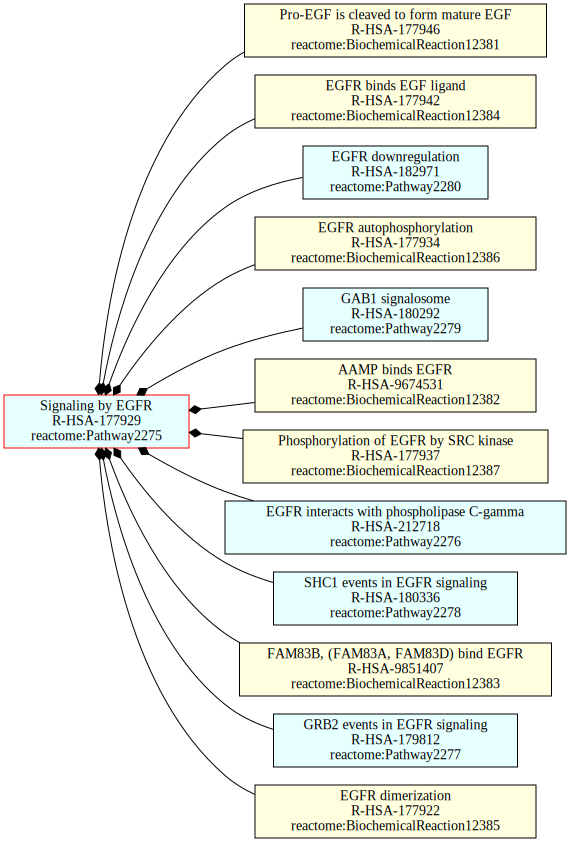

In [36]:
pathwayGraph = pgv.AGraph(directed=True, strict=True, rankdir='RL')
addPathwayComponentDirect("http://www.reactome.org/biopax/65/48887#Pathway2275", defaultPrefixName = "reactome", defaultPrefixValue = "http://www.reactome.org/biopax/{}/48887#".format(reactomeVersion), onlyPathways=False, graph = pathwayGraph)

display(IPython.core.display.SVG(pathwayGraph.draw(prog='dot',format='svg')))
pathwayGraph.draw(path='images/pathway_R-HSA-177929_components_direct.png', prog='dot',format='png')

In [37]:
def addPathwayComponentDescendants(pathwayURI, defaultPrefixName = "reactome", defaultPrefixValue = "http://www.reactome.org/biopax/{}/48887#".format(reactomeVersion), onlyPathways=False, graphDirection='BT', graph=None):
    if graph is None:
        graph = pgv.AGraph(directed=True, strict=True, rankdir=graphDirection)
    pathwayIdent = pathwayURI
    if pathwayIdent.startswith(defaultPrefixValue):
        pathwayIdent = pathwayIdent.replace(defaultPrefixValue, defaultPrefixName + ':')
    if not(pathwayIdent.startswith(defaultPrefixName + ':')):
        pathwayIdent = "<" + pathwayIdent + ">"
    if onlyPathways:
        query = """
SELECT DISTINCT ?pathwayChild ?pathwayChildName ?pathwayChildReactome ?pathwayChildType ?pathwayParent ?pathwayParentName ?pathwayParentReactome 
WHERE {
  VALUES ?pathwayStart { """ + pathwayIdent + """ }
  
  ?pathwayStart bp3:pathwayComponent* ?pathwayParent .
  
  ?pathwayParent rdf:type bp3:Pathway .
  ?pathwayParent bp3:displayName ?pathwayParentName .
  ?pathwayParent bp3:xref [ rdf:type bp3:UnificationXref ;
                      bp3:db "Reactome" ;
                      bp3:id ?pathwayParentReactome ] .
                      
  ?pathwayParent bp3:pathwayComponent ?pathwayChild .

  ?pathwayChild rdf:type bp3:Pathway .
  ?pathwayChild rdf:type ?pathwayChildType .
  ?pathwayChild bp3:displayName ?pathwayChildName .
  ?pathwayChild bp3:xref [ rdf:type bp3:UnificationXref ;
                      bp3:db "Reactome" ;
                      bp3:id ?pathwayChildReactome ] .
  
  
  
}
"""
    else:
        query = """
SELECT DISTINCT ?pathwayChild ?pathwayChildName ?pathwayChildReactome ?pathwayChildType ?pathwayParent ?pathwayParentName ?pathwayParentReactome 
WHERE {
  VALUES ?pathwayStart { """ + pathwayIdent + """ }
  
  ?pathwayStart bp3:pathwayComponent* ?pathwayParent .
  
  ?pathwayParent bp3:displayName ?pathwayParentName .
  ?pathwayParent bp3:xref [ rdf:type bp3:UnificationXref ;
                      bp3:db "Reactome" ;
                      bp3:id ?pathwayParentReactome ] .
                      
  ?pathwayParent bp3:pathwayComponent ?pathwayChild .

  ?pathwayChild rdf:type ?pathwayChildType .
  ?pathwayChild bp3:displayName ?pathwayChildName .
  ?pathwayChild bp3:xref [ rdf:type bp3:UnificationXref ;
                      bp3:db "Reactome" ;
                      bp3:id ?pathwayChildReactome ] .
  
  
  
}
"""
    sparql = SPARQLWrapper(endpointURL)
    sparql.setQuery(prefixes + query)
    sparql.setReturnFormat(JSON)
    results = sparql.queryAndConvert()
    for result in results["results"]["bindings"]:
        childID = result["pathwayChild"]["value"].replace(defaultPrefixValue, "")
        parentID = result["pathwayParent"]["value"].replace(defaultPrefixValue, "")
        nodeColor = "white"
        borderColor = "black"
        if not(graph.has_node(defaultPrefixName+childID)):
        #if defaultPrefixName+childID not in graph.nodes():
            if result["pathwayChildType"]["value"] == biopaxURI + "Pathway":
                nodeColor = colorPathway
            elif result["pathwayChildType"]["value"] == biopaxURI + "BiochemicalReaction":
                nodeColor = colorReaction
            graph.add_node(defaultPrefixName+childID, label="{}\n{}\n{}:{}".format(result["pathwayChildName"]["value"], result["pathwayChildReactome"]["value"], defaultPrefixName, childID), shape="box", style="filled", fillcolor=nodeColor, color=borderColor)
        if result["pathwayChild"]["value"] == pathwayURI:
            graph.get_node(defaultPrefixName+childID).attr["color"] = "red"
        
        nodeColor = colorPathway # "white"
        borderColor = "black"
        if not(graph.has_node(defaultPrefixName+parentID)):
        #if defaultPrefixName+parentID not in graph.nodes():
            graph.add_node(defaultPrefixName+parentID, label="{}\n{}\n{}:{}".format(result["pathwayParentName"]["value"], result["pathwayParentReactome"]["value"], defaultPrefixName, parentID), shape="box", style="filled", fillcolor=nodeColor, color=borderColor)
        if result["pathwayParent"]["value"] == pathwayURI:
            graph.get_node(defaultPrefixName+parentID).attr["color"] = "red"
        
        graph.add_edge(defaultPrefixName+childID, defaultPrefixName+parentID, arrowhead="diamond")
    return graph

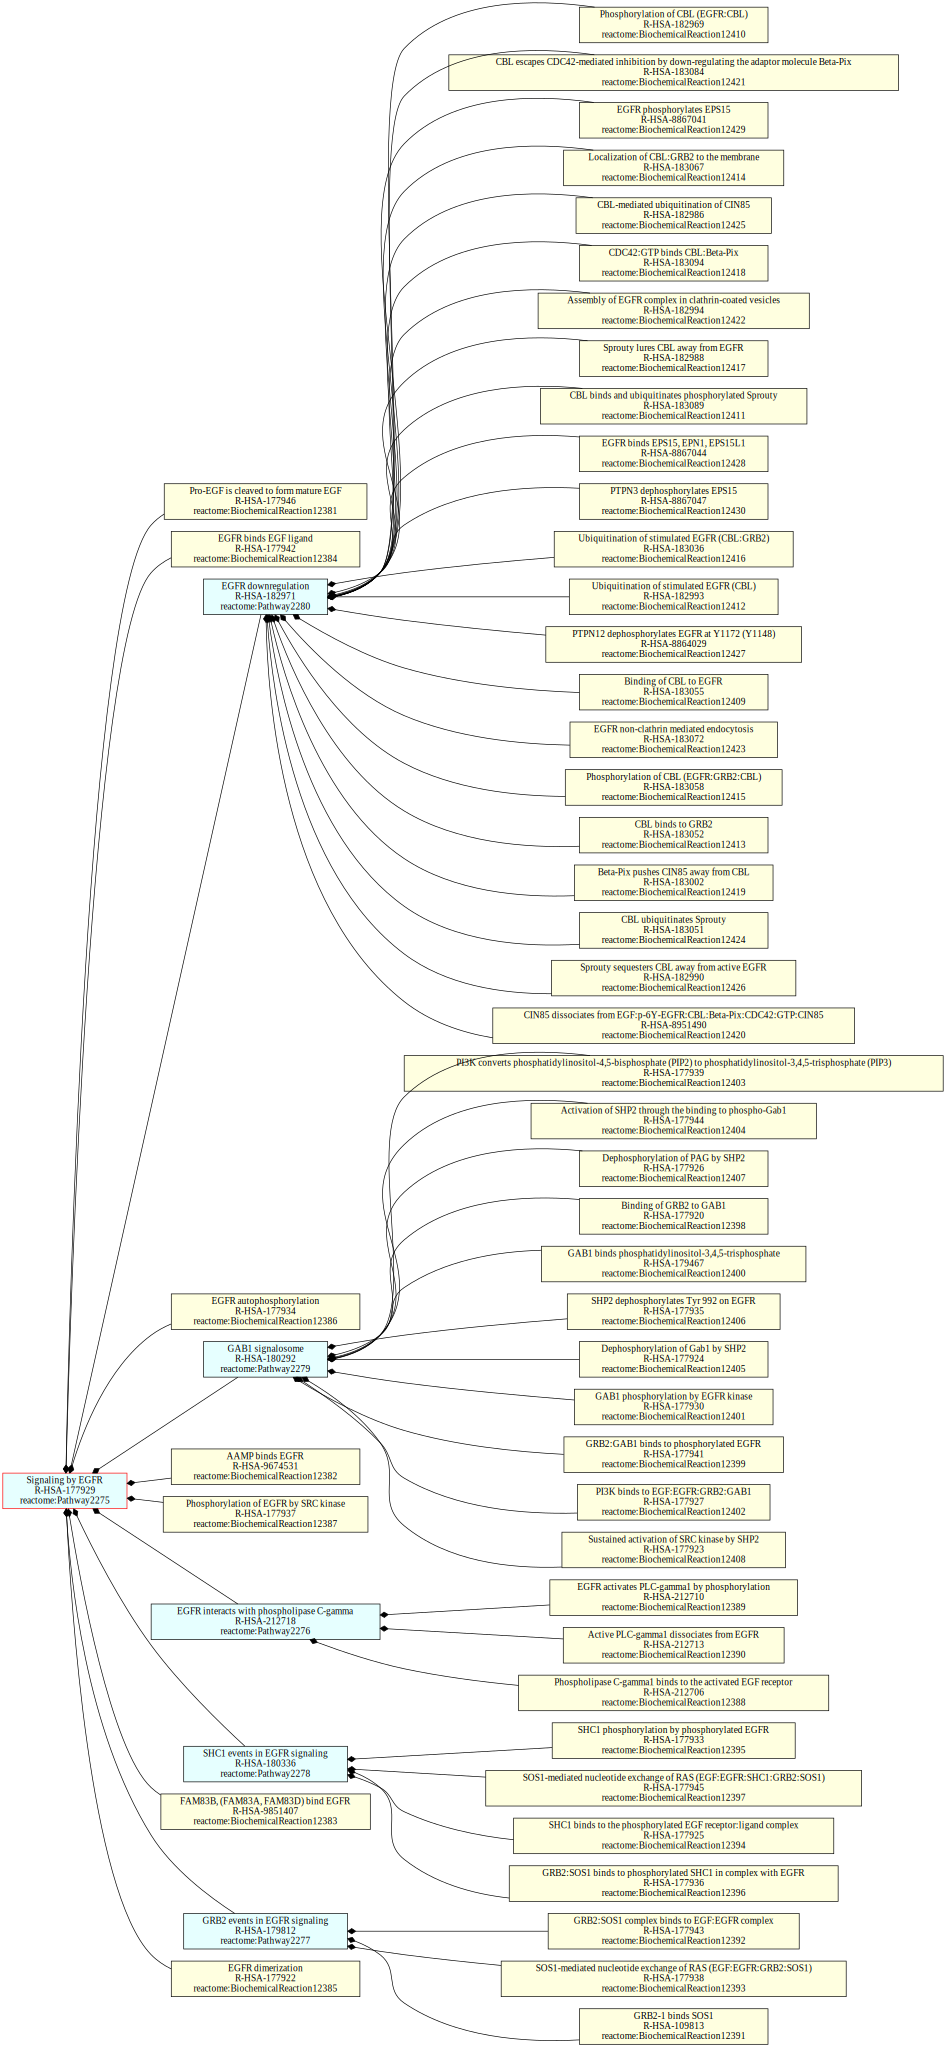

In [38]:
pathwayGraph = pgv.AGraph(directed=True, strict=True, rankdir='RL')
addPathwayComponentDescendants("http://www.reactome.org/biopax/65/48887#Pathway2275", defaultPrefixName = "reactome", defaultPrefixValue = "http://www.reactome.org/biopax/{}/48887#".format(reactomeVersion), onlyPathways=False, graph = pathwayGraph)

display(IPython.core.display.SVG(pathwayGraph.draw(prog='dot',format='svg')))
pathwayGraph.draw(path='images/pathway_R-HSA-177929_components_indirect.png', prog='dot',format='png')

# Pathway steps

In [41]:
def addPathwaySteps(pathwayURI, defaultPrefixName = "reactome", defaultPrefixValue = "http://www.reactome.org/biopax/{}/48887#".format(reactomeVersion), graphDirection='BT', graph=None):
    if graph is None:
        graph = pgv.AGraph(directed=True, strict=True, rankdir=graphDirection)
    pathwayIdent = pathwayURI
    if pathwayIdent.startswith(defaultPrefixValue):
        pathwayIdent = pathwayIdent.replace(defaultPrefixValue, defaultPrefixName + ':')
    if not(pathwayIdent.startswith(defaultPrefixName + ':')):
        pathwayIdent = "<" + pathwayIdent + ">"
    query = """
SELECT DISTINCT ?pathwayStart ?pathwayStartName ?pathwayStartReactome ?stepL ?componentL ?componentLName ?componentLReactome ?componentLType 
WHERE {
  VALUES ?pathwayRoot { """ + pathwayIdent + """ }
  
  ?pathwayRoot (bp3:pathwayOrder/bp3:stepProcess)* ?pathwayStart .
  
  ?pathwayStart bp3:pathwayOrder ?stepL .
  
  ?stepL bp3:stepProcess ?componentL .
  ?pathwayStart bp3:pathwayComponent ?componentL .
  
  
  ?pathwayStart bp3:displayName ?pathwayStartName .
  ?pathwayStart bp3:xref [ rdf:type bp3:UnificationXref ;
                      bp3:db "Reactome" ;
                      bp3:id ?pathwayStartReactome ] .


  ?componentL rdf:type ?componentLType .    
  ?componentL bp3:displayName ?componentLName .
  ?componentL bp3:xref [ rdf:type bp3:UnificationXref ;
                      bp3:db "Reactome" ;
                      bp3:id ?componentLReactome ] .
}
"""
    sparql = SPARQLWrapper(endpointURL)
    sparql.setQuery(prefixes + query)
    sparql.setReturnFormat(JSON)
    results = sparql.queryAndConvert()
    for result in results["results"]["bindings"]:
        pathwayID = result["pathwayStart"]["value"].replace(defaultPrefixValue, "")
        stepLID = result["stepL"]["value"].replace(defaultPrefixValue, "")
        componentLID = result["componentL"]["value"].replace(defaultPrefixValue, "")
        nodeColor = "white"
        borderColor = "black"
        if not(graph.has_node(defaultPrefixName+pathwayID)):
            graph.add_node(defaultPrefixName+pathwayID, label="{}\n{}\n{}:{}".format(result["pathwayStartName"]["value"], result["pathwayStartReactome"]["value"], defaultPrefixName, pathwayID), shape="box", style="filled", fillcolor=colorPathway, color=borderColor)
        if result["pathwayStart"]["value"] == pathwayURI:
            graph.get_node(defaultPrefixName+pathwayID).attr["color"] = "red"
        
        nodeColor = "white"
        #nodeColorStep = "#e6ffff" # "white"
        #nodeColorComponent = "#e8ffe8" # "white"
        nodeColorStep = "white"
        nodeColorComponent = "white"
        borderColor = "black"
        if not(graph.has_node(defaultPrefixName+stepLID)):
            graph.add_node(defaultPrefixName+stepLID, label="{}:{}".format(defaultPrefixName, stepLID), shape="box", style="filled", fillcolor=colorPathwayStep, color=borderColor)
        if not(graph.has_node(defaultPrefixName+componentLID)):
            if result["componentLType"]["value"] == biopaxURI + "Pathway":
                nodeColor = colorPathway
            elif result["componentLType"]["value"] == biopaxURI + "BiochemicalReaction":
                nodeColor = colorReaction
            graph.add_node(defaultPrefixName+componentLID, label="{}\n{}\n{}:{}".format(result["componentLName"]["value"], result["componentLReactome"]["value"], defaultPrefixName, componentLID), shape="box", style="filled", fillcolor=nodeColor, color=borderColor)
          
        graph.add_edge(defaultPrefixName+pathwayID, defaultPrefixName+stepLID, arrowhead="normal")
        graph.add_edge(defaultPrefixName+stepLID, defaultPrefixName+componentLID, arrowhead="normal")
        
    query = """
SELECT DISTINCT ?stepL ?stepR 
WHERE {
  VALUES ?pathwayRoot { """ + pathwayIdent + """ }
  
  ?pathwayRoot (bp3:pathwayOrder/bp3:stepProcess)*/bp3:pathwayOrder ?stepL .
  ?pathwayRoot (bp3:pathwayOrder/bp3:stepProcess)*/bp3:pathwayOrder ?stepR .
  
  ?stepL bp3:nextStep ?stepR .
}
"""
    sparql = SPARQLWrapper(endpointURL)
    sparql.setQuery(prefixes + query)
    sparql.setReturnFormat(JSON)
    results = sparql.queryAndConvert()
    for result in results["results"]["bindings"]:
        stepLID = result["stepL"]["value"].replace(defaultPrefixValue, "")
        stepRID = result["stepR"]["value"].replace(defaultPrefixValue, "")
        graph.add_edge(defaultPrefixName+stepLID, defaultPrefixName+stepRID, color="blue", arrowhead="open")
    return graph

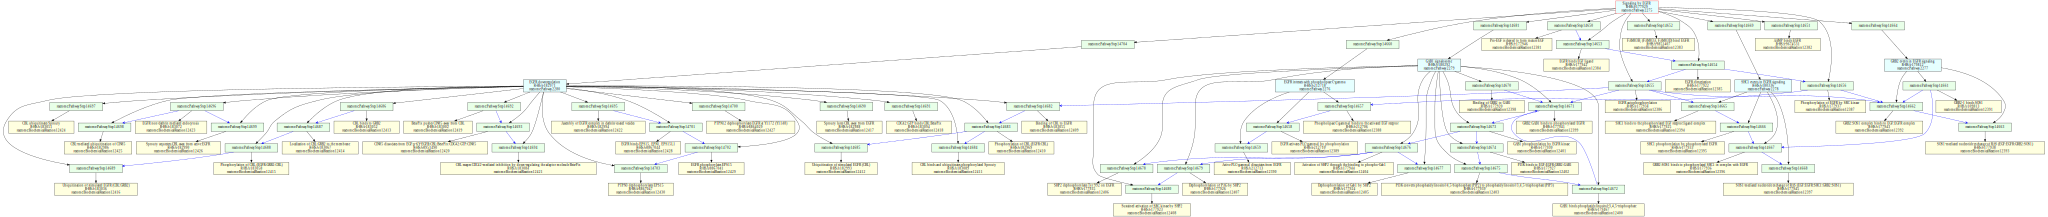

In [42]:
pathwayGraph = pgv.AGraph(directed=True, strict=True, rankdir='TB')
addPathwaySteps("http://www.reactome.org/biopax/65/48887#Pathway2275", defaultPrefixName = "reactome", defaultPrefixValue = "http://www.reactome.org/biopax/{}/48887#".format(reactomeVersion), graph = pathwayGraph)

display(IPython.core.display.SVG(pathwayGraph.draw(prog='dot',format='svg')))
pathwayGraph.draw(path='images/pathway_R-HSA-177929_steps_nextStep.png', prog='dot',format='png')

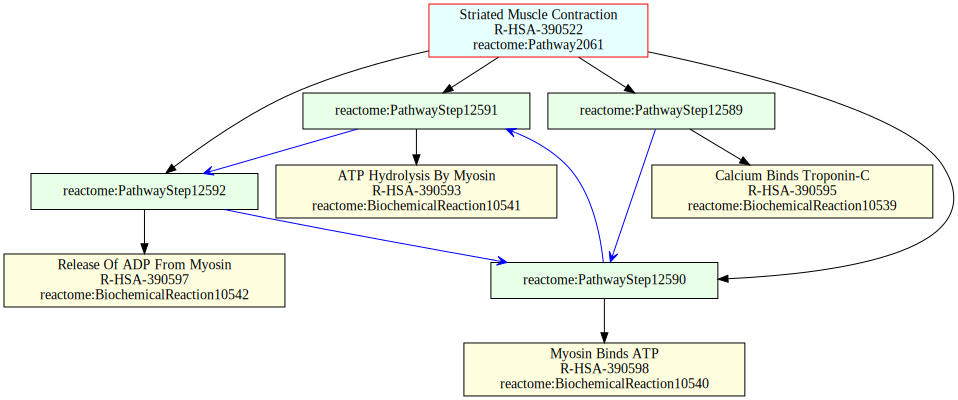

In [69]:
pathwayGraph = pgv.AGraph(directed=True, strict=True, rankdir='TB')
addPathwaySteps("http://www.reactome.org/biopax/65/48887#Pathway2061", defaultPrefixName = "reactome", defaultPrefixValue = "http://www.reactome.org/biopax/{}/48887#".format(reactomeVersion), graph = pathwayGraph)

display(IPython.core.display.SVG(pathwayGraph.draw(prog='dot',format='svg')))

## nextStep across pathways

In [32]:
query="""
# EGFR-related pathways

SELECT DISTINCT ?pathwayLName ?pathwayLIdent ?stepL ?stepR ?pathwayRName ?pathwayRIdent
WHERE {
  VALUES ?pathwayL { """ + pathwayIdent + """ }

  ?pathwayL rdf:type bp3:Pathway .
  ?pathwayL bp3:pathwayOrder ?stepL .
  ?stepL rdf:type bp3:PathwayStep .
  
  ?stepL bp3:nextStep ?stepR .
  ?pathwayR bp3:pathwayOrder ?stepR .
  ?pathwayR rdf:type bp3:Pathway .
  
  ?pathwayL bp3:pathwayComponent ?pathwayR .
  

  ?pathwayL bp3:displayName ?pathwayLName .
  ?pathwayL bp3:xref [ rdf:type bp3:UnificationXref ;
                       bp3:db "Reactome" ;
                       bp3:id ?pathwayLIdent ] .
                       
  ?pathwayR bp3:displayName ?pathwayRName .
  ?pathwayR bp3:xref [ rdf:type bp3:UnificationXref ;
                       bp3:db "Reactome" ;
                       bp3:id ?pathwayRIdent ] .

}
#LIMIT 3
ORDER BY ?stepL ?stepR
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

In [33]:
query="""
# Infered nextStep between the direct component of a pathway

SELECT DISTINCT ?componentL ?componentLIdent ?componentLName ?componentR ?componentRIdent ?componentRName
WHERE {
  VALUES ?pathway { """ + pathwayIdent + """ }

  ?pathway rdf:type bp3:Pathway .
  ?pathway bp3:pathwayComponent ?componentL .
  ?pathway bp3:pathwayComponent ?componentR .
  
  ?pathway bp3:pathwayOrder ?stepL .
  ?stepL rdf:type bp3:PathwayStep .
  ?stepL bp3:stepProcess ?componentL .
  
  ?pathway bp3:pathwayOrder ?stepR .
  ?stepR rdf:type bp3:PathwayStep .
  ?stepR bp3:stepProcess ?componentR .
  
  #?stepL bp3:nextStep ?stepR .
  ?stepL (bp3:stepProcess/bp3:pathwayOrder)* ?stepLdesc .
  ?stepR (bp3:stepProcess/bp3:pathwayOrder)* ?stepRdesc .
  ?stepLdesc bp3:nextStep ?stepRdesc .
  
  FILTER(?componentL != ?componentR)

  ?componentL bp3:displayName ?componentLName .
  ?componentL bp3:xref [ rdf:type bp3:UnificationXref ;
                       bp3:db "Reactome" ;
                       bp3:id ?componentLIdent ] .
                       
  ?componentR bp3:displayName ?componentRName .
  ?componentR bp3:xref [ rdf:type bp3:UnificationXref ;
                       bp3:db "Reactome" ;
                       bp3:id ?componentRIdent ] .

}
#LIMIT 3
ORDER BY ?stepL ?stepR
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

In [67]:
def addSequenceOfIndirectComponents(pathwayURI, defaultPrefixName = "reactome", defaultPrefixValue = "http://www.reactome.org/biopax/{}/48887#".format(reactomeVersion), graphDirection='BT', graph=None):
    if graph is None:
        graph = pgv.AGraph(directed=True, strict=True, rankdir=graphDirection)
    pathwayIdent = pathwayURI
    if pathwayIdent.startswith(defaultPrefixValue):
        pathwayIdent = pathwayIdent.replace(defaultPrefixValue, defaultPrefixName + ':')
    if not(pathwayIdent.startswith(defaultPrefixName + ':')):
        pathwayIdent = "<" + pathwayIdent + ">"
    query = """
# Infered nextStep between the indirect component of a pathway

SELECT DISTINCT ?pathway ?pathwayReactome ?pathwayName ?component ?componentReactome ?componentName ?componentType
WHERE {
  VALUES ?pathway { """ + pathwayIdent + """ }

  ?pathway rdf:type bp3:Pathway .
  ?pathway bp3:pathwayComponent+ ?component .

  ?pathway bp3:displayName ?pathwayName .
  ?pathway bp3:xref [ rdf:type bp3:UnificationXref ;
                       bp3:db "Reactome" ;
                       bp3:id ?pathwayReactome ] .
                       
  ?component rdf:type ?componentType .
  ?component bp3:displayName ?componentName .
  ?component bp3:xref [ rdf:type bp3:UnificationXref ;
                       bp3:db "Reactome" ;
                       bp3:id ?componentReactome ] .

}
"""
    sparql = SPARQLWrapper(endpointURL)
    sparql.setQuery(prefixes + query)
    sparql.setReturnFormat(JSON)
    results = sparql.queryAndConvert()
    for result in results["results"]["bindings"]:
        pathwayID = result["pathway"]["value"].replace(defaultPrefixValue, "")
        componentID = result["component"]["value"].replace(defaultPrefixValue, "")
        nodeColor = "white"
        borderColor = "black"
        #if not(graph.has_node(defaultPrefixName+pathwayID)):
        #    graph.add_node(defaultPrefixName+pathwayID, label="{}\n{}\n{}:{}".format(result["pathwayName"]["value"], result["pathwayReactome"]["value"], defaultPrefixName, pathwayID), shape="box", style="filled", fillcolor=colorPathway, color=borderColor)
        if not(graph.has_node(defaultPrefixName+componentID)):
            if result["componentType"]["value"] == biopaxURI + "Pathway":
                nodeColor = colorPathway
            elif result["componentType"]["value"] == biopaxURI + "BiochemicalReaction":
                nodeColor = colorReaction
            graph.add_node(defaultPrefixName+componentID, label="{}\n{}\n{}:{}".format(result["componentName"]["value"], result["componentReactome"]["value"], defaultPrefixName, componentID), shape="box", style="filled", fillcolor=nodeColor, color=borderColor)
        #graph.add_edge(defaultPrefixName+pathwayID, defaultPrefixName+componentID, arrowhead="diamond")
    
    query = """
# Infered nextStep between the direct component of a pathway

SELECT DISTINCT ?componentL ?componentLReactome ?componentLName ?componentLType ?componentR ?componentRReactome ?componentRName ?componentRType
WHERE {
  VALUES ?pathway { """ + pathwayIdent + """ }

  ?pathway rdf:type bp3:Pathway .
  ?pathway bp3:pathwayComponent+ ?componentL .
  ?pathway bp3:pathwayComponent+ ?componentR .
  
  ?pathway bp3:pathwayOrder/(bp3:stepProcess/bp3:pathwayOrder)* ?stepL .
  ?stepL rdf:type bp3:PathwayStep .
  ?stepL bp3:stepProcess ?componentL .
  
  ?pathway bp3:pathwayOrder/(bp3:stepProcess/bp3:pathwayOrder)* ?stepR .
  ?stepR rdf:type bp3:PathwayStep .
  ?stepR bp3:stepProcess ?componentR .
  
  ?stepL bp3:nextStep ?stepR .
  
  FILTER(?componentL != ?componentR)

  ?componentL rdf:type ?componentLType .
  ?componentL bp3:displayName ?componentLName .
  ?componentL bp3:xref [ rdf:type bp3:UnificationXref ;
                       bp3:db "Reactome" ;
                       bp3:id ?componentLReactome ] .
  
  ?componentR rdf:type ?componentRType .
  ?componentR bp3:displayName ?componentRName .
  ?componentR bp3:xref [ rdf:type bp3:UnificationXref ;
                       bp3:db "Reactome" ;
                       bp3:id ?componentRReactome ] .

}
"""
    sparql = SPARQLWrapper(endpointURL)
    sparql.setQuery(prefixes + query)
    sparql.setReturnFormat(JSON)
    results = sparql.queryAndConvert()
    for result in results["results"]["bindings"]:
        componentLID = result["componentL"]["value"].replace(defaultPrefixValue, "")
        componentRID = result["componentR"]["value"].replace(defaultPrefixValue, "")
        nodeColor = "white"
        borderColor = "black"
        if not(graph.has_node(defaultPrefixName+componentLID)):
            if result["componentLType"]["value"] == biopaxURI + "Pathway":
                nodeColor = colorPathway
            elif result["componentLType"]["value"] == biopaxURI + "BiochemicalReaction":
                nodeColor = colorReaction
            graph.add_node(defaultPrefixName+componentLID, label="{}\n{}\n{}:{}".format(result["componentLName"]["value"], result["componentLReactome"]["value"], defaultPrefixName, componentLID), shape="box", style="filled", fillcolor=nodeColor, color=borderColor)
        if not(graph.has_node(defaultPrefixName+componentRID)):
            if result["componentRType"]["value"] == biopaxURI + "Pathway":
                nodeColor = colorPathway
            elif result["componentRType"]["value"] == biopaxURI + "BiochemicalReaction":
                nodeColor = colorReaction
            graph.add_node(defaultPrefixName+componentRID, label="{}\n{}\n{}:{}".format(result["componentRName"]["value"], result["componentRReactome"]["value"], defaultPrefixName, componentRID), shape="box", style="filled", fillcolor=nodeColor, color=borderColor)
        graph.add_edge(defaultPrefixName+componentLID, defaultPrefixName+componentRID, arrowhead="normal", color="blue")
    
    return graph

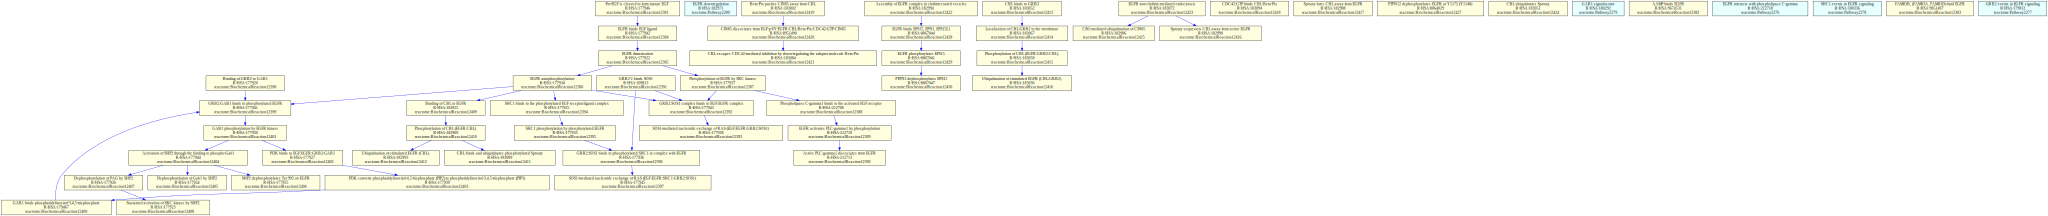

In [68]:
pathwayGraph = pgv.AGraph(directed=True, strict=True, rankdir='TB')
addSequenceOfIndirectComponents("http://www.reactome.org/biopax/65/48887#Pathway2275", defaultPrefixName = "reactome", defaultPrefixValue = "http://www.reactome.org/biopax/{}/48887#".format(reactomeVersion), graph = pathwayGraph)

display(IPython.core.display.SVG(pathwayGraph.draw(prog='dot',format='svg')))
pathwayGraph.draw(path='images/pathway_R-HSA-177929_indirectComponents_nextStep.png', prog='dot',format='png')

In [86]:
def findSubgraph(graph, subgraphName):
    result = graph.get_subgraph(subgraphName)
    if result is not None:
        return result
    for subgraph in graph.subgraphs():
        result = findSubgraph(subgraph, subgraphName)
        if result is not None:
            return result
    return None

def addSequenceOfIndirectComponentsWithPathways(pathwayURI, defaultPrefixName = "reactome", defaultPrefixValue = "http://www.reactome.org/biopax/{}/48887#".format(reactomeVersion), graphDirection='BT', graph=None):
    if graph is None:
        graph = pgv.AGraph(directed=True, strict=True, rankdir=graphDirection)
    pathwayIdent = pathwayURI
    if pathwayIdent.startswith(defaultPrefixValue):
        pathwayIdent = pathwayIdent.replace(defaultPrefixValue, defaultPrefixName + ':')
    if not(pathwayIdent.startswith(defaultPrefixName + ':')):
        pathwayIdent = "<" + pathwayIdent + ">"
    query = """
# components that are not pathways

SELECT DISTINCT ?pathway ?pathwayReactome ?pathwayName ?component ?componentReactome ?componentName ?componentType
WHERE {
  VALUES ?pathwayStart { """ + pathwayIdent + """ }
  
  ?pathwayStart bp3:pathwayComponent* ?pathway .

  ?pathway rdf:type bp3:Pathway .
  ?pathway bp3:pathwayComponent ?component .
  
  ?component rdf:type ?componentType .
  #FILTER NOT EXISTS {
  #  ?componentTpe rdfs:subClassOf* bp3:Pathway .
  #}
  
  ?pathway bp3:displayName ?pathwayName .
  ?pathway bp3:xref [ rdf:type bp3:UnificationXref ;
                       bp3:db "Reactome" ;
                       bp3:id ?pathwayReactome ] .

  ?component bp3:displayName ?componentName .
  ?component bp3:xref [ rdf:type bp3:UnificationXref ;
                       bp3:db "Reactome" ;
                       bp3:id ?componentReactome ] .

}
"""
    sparql = SPARQLWrapper(endpointURL)
    sparql.setQuery(prefixes + query)
    sparql.setReturnFormat(JSON)
    results = sparql.queryAndConvert()
    #pathwayToComponents = collection.defaultdict(list)
    for result in results["results"]["bindings"]:
        pathwayID = result["pathway"]["value"].replace(defaultPrefixValue, "")
        componentID = result["component"]["value"].replace(defaultPrefixValue, "")
        nodeColor = "white"
        borderColor = "black"
        
        pathwaySubgraph = findSubgraph(graph, "cluster_" + pathwayID)
        if pathwaySubgraph is None:
            graph.add_subgraph(nbunch=[], name="cluster_" + pathwayID, style='dashed', color='grey', label="{}\n{}\n{}:{}".format(result["pathwayName"]["value"], result["pathwayReactome"]["value"], defaultPrefixName, pathwayID))
            pathwaySubgraph = graph.get_subgraph("cluster_" + pathwayID)
        if result["componentType"]["value"] == biopaxURI + "Pathway":
            subpathwaySubgraph = findSubgraph(graph, "cluster_" + componentID)
            if subpathwaySubgraph is None:
                pathwaySubgraph.add_subgraph(nbunch=[], name="cluster_" + componentID, style='dashed', color='grey', label="{}\n{}\n{}:{}".format(result["componentName"]["value"], result["componentReactome"]["value"], defaultPrefixName, componentID))
                subpathwaySubgraph = pathwaySubgraph.get_subgraph("cluster_" + componentID)
        else:
            if result["componentType"]["value"] == biopaxURI + "BiochemicalReaction":
                nodeColor = colorReaction
            pathwaySubgraph.add_node(defaultPrefixName+componentID, label="{}\n{}\n{}:{}".format(result["componentName"]["value"], result["componentReactome"]["value"], defaultPrefixName, componentID), shape="box", style="filled", fillcolor=nodeColor, color=borderColor)
        
        
        #if graph.get_subgraph("cluster_" + pathwayID) is None:
        #    graph.add_subgraph(nbunch=[], name="cluster_" + pathwayID, style='dashed', color='grey', label="{}\n{}\n{}:{}".format(result["pathwayName"]["value"], result["pathwayReactome"]["value"], defaultPrefixName, pathwayID))
        #if result["componentType"]["value"] == biopaxURI + "Pathway":
        #    print("Add subpathway {} -> {}".format(pathwayID, componentID))
        #    if graph.get_subgraph("cluster_" + componentID) is None:
        #        graph.add_subgraph(nbunch=[], name="cluster_" + componentID, style='dashed', color='grey', label="{}\n{}\n{}:{}".format(result["componentName"]["value"], result["componentReactome"]["value"], defaultPrefixName, componentID))
        #    graph.get_subgraph("cluster_" + pathwayID).add_subgraph("cluster_" + componentID)
        #else:
        #    print("Add component {} -> {}".format(pathwayID, componentID))
        #    graph.get_subgraph("cluster_" + pathwayID).add_node(defaultPrefixName+componentID, label="{}\n{}\n{}:{}".format(result["componentName"]["value"], result["componentReactome"]["value"], defaultPrefixName, componentID), shape="box", style="filled", fillcolor=nodeColor, color=borderColor)
        
        #if not(graph.has_node(defaultPrefixName+pathwayID)):
        #    graph.add_node(defaultPrefixName+pathwayID, label="{}\n{}\n{}:{}".format(result["pathwayName"]["value"], result["pathwayReactome"]["value"], defaultPrefixName, pathwayID), shape="box", style="filled", fillcolor=nodeColor, color=borderColor)
        #if not(graph.has_node(defaultPrefixName+componentID)):
        #    graph.add_node(defaultPrefixName+componentID, label="{}\n{}\n{}:{}".format(result["componentName"]["value"], result["componentReactome"]["value"], defaultPrefixName, componentID), shape="box", style="filled", fillcolor=nodeColor, color=borderColor)
        #graph.add_edge(defaultPrefixName+pathwayID, defaultPrefixName+componentID, arrowhead="diamond")
        
    query = """
# Infered nextStep between the direct component of a pathway

SELECT DISTINCT ?componentL ?componentLReactome ?componentLName ?componentR ?componentRReactome ?componentRName
WHERE {
  VALUES ?pathway { """ + pathwayIdent + """ }

  ?pathway rdf:type bp3:Pathway .
  ?pathway bp3:pathwayComponent+ ?componentL .
  ?pathway bp3:pathwayComponent+ ?componentR .
  
  ?pathway bp3:pathwayOrder/(bp3:stepProcess/bp3:pathwayOrder)* ?stepL .
  ?stepL rdf:type bp3:PathwayStep .
  ?stepL bp3:stepProcess ?componentL .
  
  ?pathway bp3:pathwayOrder/(bp3:stepProcess/bp3:pathwayOrder)* ?stepR .
  ?stepR rdf:type bp3:PathwayStep .
  ?stepR bp3:stepProcess ?componentR .
  
  ?stepL bp3:nextStep ?stepR .
  
  FILTER(?componentL != ?componentR)

  ?componentL bp3:displayName ?componentLName .
  ?componentL bp3:xref [ rdf:type bp3:UnificationXref ;
                       bp3:db "Reactome" ;
                       bp3:id ?componentLReactome ] .
                       
  ?componentR bp3:displayName ?componentRName .
  ?componentR bp3:xref [ rdf:type bp3:UnificationXref ;
                       bp3:db "Reactome" ;
                       bp3:id ?componentRReactome ] .

}
"""
    sparql = SPARQLWrapper(endpointURL)
    sparql.setQuery(prefixes + query)
    sparql.setReturnFormat(JSON)
    results = sparql.queryAndConvert()
    for result in results["results"]["bindings"]:
        componentLID = result["componentL"]["value"].replace(defaultPrefixValue, "")
        componentRID = result["componentR"]["value"].replace(defaultPrefixValue, "")
        nodeColor = "white"
        borderColor = "black"
        #if not(graph.has_node(defaultPrefixName+componentLID)):
        #    graph.add_node(defaultPrefixName+componentLID, label="{}\n{}\n{}:{}".format(result["componentLName"]["value"], result["componentLReactome"]["value"], defaultPrefixName, componentLID), shape="box", style="filled", fillcolor=nodeColor, color=borderColor)
        #if not(graph.has_node(defaultPrefixName+componentRID)):
        #    graph.add_node(defaultPrefixName+componentRID, label="{}\n{}\n{}:{}".format(result["componentRName"]["value"], result["componentRReactome"]["value"], defaultPrefixName, componentRID), shape="box", style="filled", fillcolor=nodeColor, color=borderColor)
        graph.add_edge(defaultPrefixName+componentLID, defaultPrefixName+componentRID, arrowhead="normal", color="blue")
    
    return graph

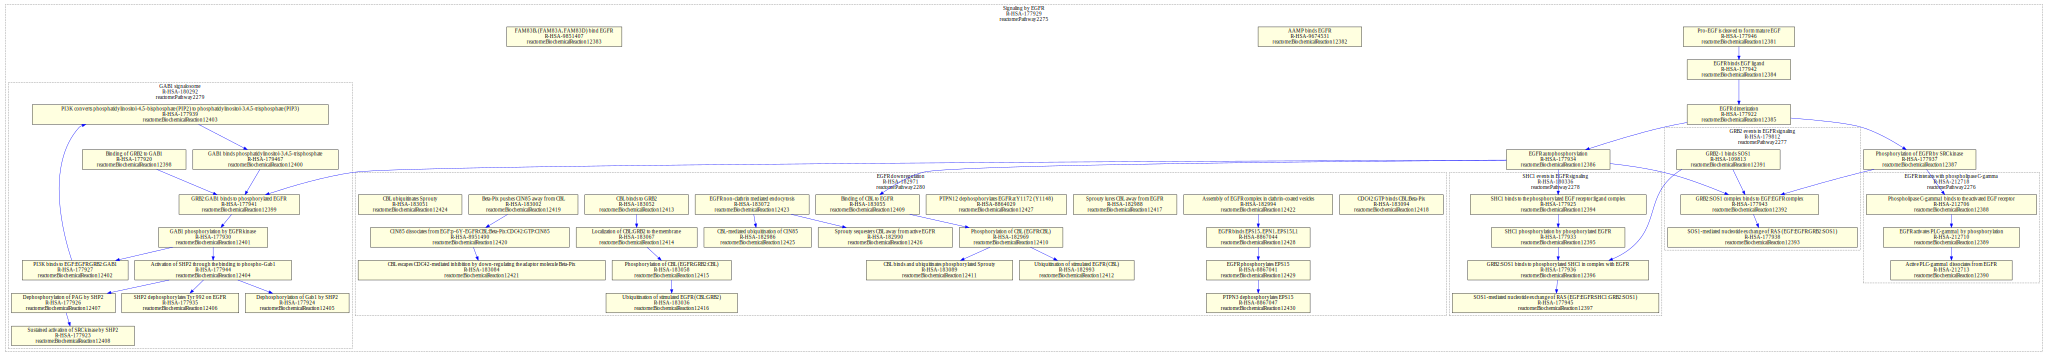

In [87]:
pathwayGraph = pgv.AGraph(directed=True, strict=True, rankdir='TB')
addSequenceOfIndirectComponentsWithPathways("http://www.reactome.org/biopax/65/48887#Pathway2275", defaultPrefixName = "reactome", defaultPrefixValue = "http://www.reactome.org/biopax/{}/48887#".format(reactomeVersion), graph = pathwayGraph)

display(IPython.core.display.SVG(pathwayGraph.draw(prog='dot',format='svg')))
pathwayGraph.draw(path='images/pathway_R-HSA-177929_indirectComponents_withPathways_nextStep.png', prog='dot',format='png')

In [82]:
def addSequenceOfDirectComponents(pathwayURI, defaultPrefixName = "reactome", defaultPrefixValue = "http://www.reactome.org/biopax/{}/48887#".format(reactomeVersion), graphDirection='BT', graph=None):
    if graph is None:
        graph = pgv.AGraph(directed=True, strict=True, rankdir=graphDirection)
    pathwayIdent = pathwayURI
    if pathwayIdent.startswith(defaultPrefixValue):
        pathwayIdent = pathwayIdent.replace(defaultPrefixValue, defaultPrefixName + ':')
    if not(pathwayIdent.startswith(defaultPrefixName + ':')):
        pathwayIdent = "<" + pathwayIdent + ">"
    query = """
# Infered nextStep between the direct component of a pathway

SELECT DISTINCT ?pathway ?pathwayReactome ?pathwayName ?component ?componentReactome ?componentName ?componentType
WHERE {
  VALUES ?pathway { """ + pathwayIdent + """ }

  ?pathway rdf:type bp3:Pathway .
  ?pathway bp3:pathwayComponent ?component .

  ?pathway bp3:displayName ?pathwayName .
  ?pathway bp3:xref [ rdf:type bp3:UnificationXref ;
                       bp3:db "Reactome" ;
                       bp3:id ?pathwayReactome ] .
                       
  ?component rdf:type ?componentType .
  ?component bp3:displayName ?componentName .
  ?component bp3:xref [ rdf:type bp3:UnificationXref ;
                       bp3:db "Reactome" ;
                       bp3:id ?componentReactome ] .

}
"""
    sparql = SPARQLWrapper(endpointURL)
    sparql.setQuery(prefixes + query)
    sparql.setReturnFormat(JSON)
    results = sparql.queryAndConvert()
    for result in results["results"]["bindings"]:
        pathwayID = result["pathway"]["value"].replace(defaultPrefixValue, "")
        componentID = result["component"]["value"].replace(defaultPrefixValue, "")
        nodeColor = "white"
        borderColor = "black"
        #if not(graph.has_node(defaultPrefixName+pathwayID)):
        #    graph.add_node(defaultPrefixName+pathwayID, label="{}\n{}\n{}:{}".format(result["pathwayName"]["value"], result["pathwayReactome"]["value"], defaultPrefixName, pathwayID), shape="box", style="filled", fillcolor=nodeColor, color=borderColor)
        if not(graph.has_node(defaultPrefixName+componentID)):
            if result["componentType"]["value"] == biopaxURI + "Pathway":
                nodeColor = colorPathway
            elif result["componentType"]["value"] == biopaxURI + "BiochemicalReaction":
                nodeColor = colorReaction
            graph.add_node(defaultPrefixName+componentID, label="{}\n{}\n{}:{}".format(result["componentName"]["value"], result["componentReactome"]["value"], defaultPrefixName, componentID), shape="box", style="filled", fillcolor=nodeColor, color=borderColor)
        #graph.add_edge(defaultPrefixName+pathwayID, defaultPrefixName+componentID, arrowhead="diamond")
    
    query = """
# Infered nextStep between the direct component of a pathway

SELECT DISTINCT ?componentL ?componentLReactome ?componentLName ?componentR ?componentRReactome ?componentRName
WHERE {
  VALUES ?pathway { """ + pathwayIdent + """ }

  ?pathway rdf:type bp3:Pathway .
  ?pathway bp3:pathwayComponent ?componentL .
  ?pathway bp3:pathwayComponent ?componentR .
  
  ?pathway bp3:pathwayOrder ?stepL .
  ?stepL rdf:type bp3:PathwayStep .
  ?stepL bp3:stepProcess ?componentL .
  
  ?pathway bp3:pathwayOrder ?stepR .
  ?stepR rdf:type bp3:PathwayStep .
  ?stepR bp3:stepProcess ?componentR .
  
  ?stepL bp3:nextStep ?stepR .
  #?stepL (bp3:stepProcess/bp3:pathwayOrder)* ?stepLdesc .
  #?stepR (bp3:stepProcess/bp3:pathwayOrder)* ?stepRdesc .
  #?stepLdesc bp3:nextStep ?stepRdesc .
  
  FILTER(?componentL != ?componentR)

  ?componentL bp3:displayName ?componentLName .
  ?componentL bp3:xref [ rdf:type bp3:UnificationXref ;
                       bp3:db "Reactome" ;
                       bp3:id ?componentLReactome ] .
                       
  ?componentR bp3:displayName ?componentRName .
  ?componentR bp3:xref [ rdf:type bp3:UnificationXref ;
                       bp3:db "Reactome" ;
                       bp3:id ?componentRReactome ] .

}
"""
    sparql = SPARQLWrapper(endpointURL)
    sparql.setQuery(prefixes + query)
    sparql.setReturnFormat(JSON)
    results = sparql.queryAndConvert()
    for result in results["results"]["bindings"]:
        componentLID = result["componentL"]["value"].replace(defaultPrefixValue, "")
        componentRID = result["componentR"]["value"].replace(defaultPrefixValue, "")
        nodeColor = "white"
        borderColor = "black"
        if not(graph.has_node(defaultPrefixName+componentLID)):
            graph.add_node(defaultPrefixName+componentLID, label="{}\n{}\n{}:{}".format(result["componentLName"]["value"], result["componentLReactome"]["value"], defaultPrefixName, componentLID), shape="box", style="filled", fillcolor=nodeColor, color=borderColor)
        if not(graph.has_node(defaultPrefixName+componentRID)):
            graph.add_node(defaultPrefixName+componentRID, label="{}\n{}\n{}:{}".format(result["componentRName"]["value"], result["componentRReactome"]["value"], defaultPrefixName, componentRID), shape="box", style="filled", fillcolor=nodeColor, color=borderColor)
        graph.add_edge(defaultPrefixName+componentLID, defaultPrefixName+componentRID, arrowhead="normal", color="blue")
    
    query = """
# Infered nextStep between the direct component of a pathway

SELECT DISTINCT ?componentL ?componentLReactome ?componentLName ?componentR ?componentRReactome ?componentRName
WHERE {
  VALUES ?pathway { """ + pathwayIdent + """ }

  ?pathway rdf:type bp3:Pathway .
  ?pathway bp3:pathwayComponent ?componentL .
  ?pathway bp3:pathwayComponent ?componentR .
  
  ?pathway bp3:pathwayOrder ?stepL .
  ?stepL rdf:type bp3:PathwayStep .
  ?stepL bp3:stepProcess ?componentL .
  
  ?pathway bp3:pathwayOrder ?stepR .
  ?stepR rdf:type bp3:PathwayStep .
  ?stepR bp3:stepProcess ?componentR .
  
  #?stepL bp3:nextStep ?stepR .
  ?stepL (bp3:stepProcess/bp3:pathwayOrder)* ?stepLdesc .
  ?stepR (bp3:stepProcess/bp3:pathwayOrder)* ?stepRdesc .
  ?stepLdesc bp3:nextStep ?stepRdesc .
  
  FILTER(?componentL != ?componentR)

  ?componentL bp3:displayName ?componentLName .
  ?componentL bp3:xref [ rdf:type bp3:UnificationXref ;
                       bp3:db "Reactome" ;
                       bp3:id ?componentLReactome ] .
                       
  ?componentR bp3:displayName ?componentRName .
  ?componentR bp3:xref [ rdf:type bp3:UnificationXref ;
                       bp3:db "Reactome" ;
                       bp3:id ?componentRReactome ] .

}
"""
    sparql = SPARQLWrapper(endpointURL)
    sparql.setQuery(prefixes + query)
    sparql.setReturnFormat(JSON)
    results = sparql.queryAndConvert()
    for result in results["results"]["bindings"]:
        componentLID = result["componentL"]["value"].replace(defaultPrefixValue, "")
        componentRID = result["componentR"]["value"].replace(defaultPrefixValue, "")
        nodeColor = "white"
        borderColor = "black"
        if not(graph.has_node(defaultPrefixName+componentLID)):
            graph.add_node(defaultPrefixName+componentLID, label="{}\n{}\n{}:{}".format(result["componentLName"]["value"], result["componentLReactome"]["value"], defaultPrefixName, componentLID), shape="box", style="filled", fillcolor=nodeColor, color=borderColor)
        if not(graph.has_node(defaultPrefixName+componentRID)):
            graph.add_node(defaultPrefixName+componentRID, label="{}\n{}\n{}:{}".format(result["componentRName"]["value"], result["componentRReactome"]["value"], defaultPrefixName, componentRID), shape="box", style="filled", fillcolor=nodeColor, color=borderColor)
        if not graph.has_edge(defaultPrefixName+componentLID, defaultPrefixName+componentRID):
            graph.add_edge(defaultPrefixName+componentLID, defaultPrefixName+componentRID, arrowhead="normal", style="dashed", color="blue")
    
    return graph

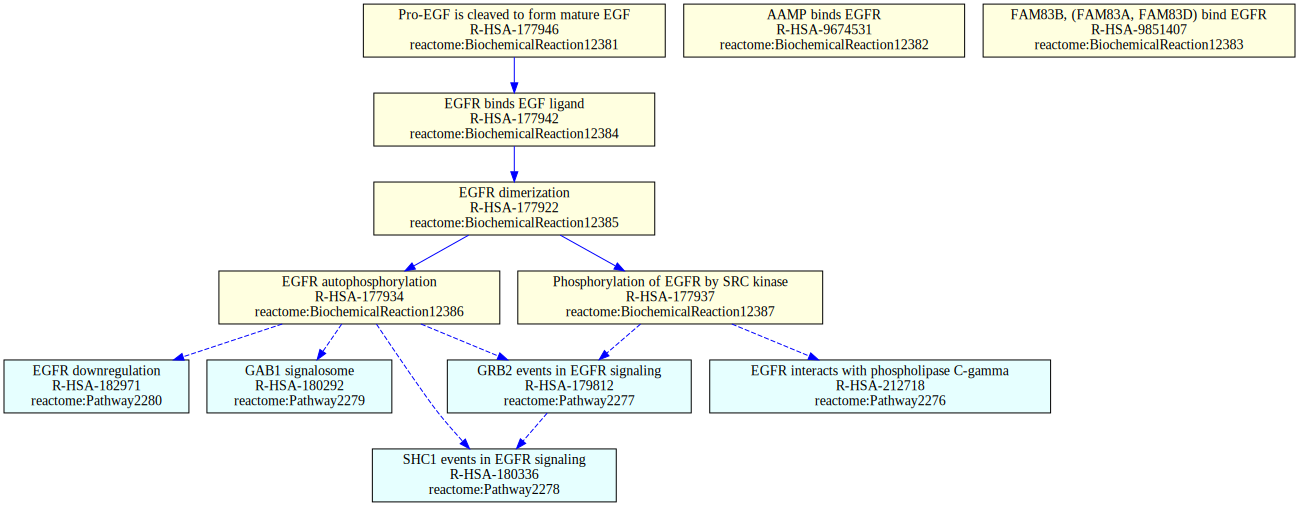

In [83]:
pathwayGraph = pgv.AGraph(directed=True, strict=True, rankdir='TB')
addSequenceOfDirectComponents("http://www.reactome.org/biopax/65/48887#Pathway2275", defaultPrefixName = "reactome", defaultPrefixValue = "http://www.reactome.org/biopax/{}/48887#".format(reactomeVersion), graph = pathwayGraph)

display(IPython.core.display.SVG(pathwayGraph.draw(prog='dot',format='svg')))
pathwayGraph.draw(path='images/pathway_R-HSA-177929_directComponents_nextStep.png', prog='dot',format='png')